In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from scipy.linalg import svd
from tqdm import tqdm

In [5]:
def WNNM(img, patchSize, delta, c, K, sigma_n, N_threshold):
    windowSize = 3 * patchSize
    pad = windowSize + patchSize
    paddedImg = np.pad(img, pad_width=pad)
    paddedImg = paddedImg[..., pad:-pad]
    X_hat = img
    N_iter = 3
    progress_bar = tqdm(total=K, desc="Processing", unit="iteration")
    for n in range(K):
        X_hat = np.pad(X_hat, pad_width=pad)
        X_hat = X_hat[..., pad:-pad]
        Y_hat = X_hat + delta * (paddedImg - X_hat )
        counting_update_numbers = np.ones_like(paddedImg)

        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                mainPatch = Y_hat[i + windowSize:i + windowSize+ 2* patchSize, j + windowSize :j + windowSize + 2* patchSize,: ]
                distances = np.ones(((2 * windowSize + 1) ** 2))
                patches = np.zeros(((2 * windowSize + 1) ** 2, (2 * patchSize) ** 2))

                for k in range(2 * windowSize + 1):
                    otherPatch = Y_hat[i : i + 2* pad , j + k:j + k + 2*patchSize,:]
                    indexer = np.arange((2 * patchSize) ** 2)[None, :] + (2 * patchSize) * np.arange(otherPatch.shape[0] - 2 * patchSize + 1)[:, None]
                    otherPatch = otherPatch.flatten()
                    otherPatch = np.reshape(otherPatch[indexer], (otherPatch[indexer].shape[0], (2 * patchSize) ** 2))
                    distances[k * (2 * windowSize +1 ):(k + 1) * (2 * windowSize  +1 )] = (np.sum((mainPatch.reshape(((2 * patchSize) ** 2)) - otherPatch) ** 2, axis=1) / ((2 * patchSize ) ** 2)).flatten()
                    patches[k * (2 * windowSize + 1):(k + 1) * (2 * windowSize + 1), :] = otherPatch

                indcs = np.argsort(distances)
                Yj = patches[indcs[:N_threshold], :].transpose()

                Yj_means = np.sum(Yj, axis=0)
                Yj_center = Yj - Yj_means

                U, S, V_T = svd(Yj_center, full_matrices=False)
                sing_val = np.sqrt(np.maximum(S ** 2 - N_threshold * sigma_n ** 2, 0))

                for m in range(N_iter):
                    w = c * np.sqrt(N_threshold) / (sing_val + 10 ** (-6))
                    sing_val = np.diag(np.maximum(S - w, 0))

                Xj_hat_center = U @ np.diag(np.maximum(S - w, 0)) @ V_T
                Xj_hat = Xj_hat_center + Yj_means

                X_hat[i + windowSize:i +windowSize+ 2* patchSize,
                      j + windowSize :j + windowSize + 2* patchSize,: ] = X_hat[i + windowSize:i +windowSize+ 2* patchSize,
                                                                                j + windowSize :j + windowSize + 2* patchSize,: ] + np.clip(Xj_hat[:, 0].reshape((2 * patchSize, 2 * patchSize, 1)), 0, 1)

                counting_update_numbers[i+windowSize:i+windowSize+2*patchSize,
                                 j+windowSize:j+windowSize+2*patchSize,
                                 :] = counting_update_numbers[i+windowSize:i+windowSize+2*patchSize,
                                 j+windowSize:j+windowSize+2*patchSize,
                                 :]+ np.ones_like(counting_update_numbers[i+windowSize:i+windowSize+2*patchSize,
                                 j+windowSize:j+windowSize+2*patchSize,
                                 :])
        X_hat = X_hat[pad:-pad, pad:-pad, :] / counting_update_numbers[pad:-pad, pad:-pad, :]
        progress_bar.update(1)

    progress_bar.close()
    return X_hat


Processing: 100%|██████████| 3/3 [53:10<00:00, 1063.55s/iteration]


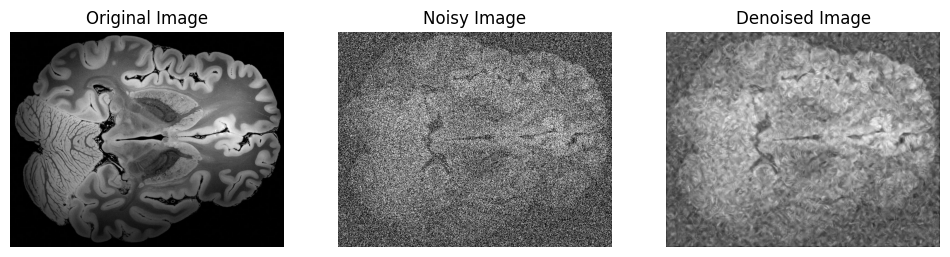

In [12]:
# Load the image and add noise
img = cv.imread('/content/Low Matrix Approximation question.jpg', 0) / 255.0
sigmaNoise = 1
noisyImg = np.clip(img + np.random.normal(loc=0.0, scale=sigmaNoise, size=img.shape), 0, 1)

# Set parameters
patchRadius = 3
delta = 0.1
c = 2.8
K = 3
sigma_n = 1
N_threshold = 50

# Denoise the image using WNNM
denoised_img = WNNM(noisyImg.reshape((noisyImg.shape[0], noisyImg.shape[1], 1)), patchRadius, delta, c, K, sigma_n, N_threshold).reshape((noisyImg.shape[0], noisyImg.shape[1]))

# Display the original, noisy, and denoised images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisyImg, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(denoised_img, cmap='gray')
plt.title('Denoised Image')
plt.axis('off')

plt.show()


In [18]:
cv.imwrite('denoised_image.png', denoised_img * 255)

True

In [17]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
ssim_denoised = ssim(img, denoised_img)
psnr_denoised = psnr(img, denoised_img)
ssim_Noisy=ssim(img,noisyImg)
psnr_Noisy=psnr(img, noisyImg)
print(f"SSIM Denoised: {ssim_denoised:.4f}")
print(f"PSNR Denoised: {psnr_denoised:.2f} dB")
print(f"SSIM Noisy: {ssim_Noisy:.4f}")
print(f"PSNR Noisy: {psnr_Noisy:.2f} dB")

SSIM Denoised: 0.3987
PSNR Denoised: 13.42 dB
SSIM Noisy: 0.0239
PSNR Noisy: 6.66 dB
